In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import r2_score
from scipy.stats import norm
from sklearn.cluster import KMeans
import random
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Default parameters

In [4]:
# number of items
n = 20

# number of features
d = 5

# number of observations for each item
obs = 10

# number of clusters
z = 2

# number of trials
T = 100

# noise
sigma = 1
# prob
p, q = 2/3, 1/6

# Generate the simulated training and testing dataset and trains the models

In [5]:
# gamma is the proportion of items that simulate new items (lower number of observations)
# a: number of observations for new items
# b: number of observations for old items

In [7]:
def fit_models_test(gamma,a,b,Ru,Rl):
    
    n_low = int(round(gamma*n))
    n_high = n-n_low

    
    
    r2_alg_t, r2_b1_t, r2_b2_t, r2_lasso_t, r2_clus_t,r2_alg_t_old,r2_alg_t_new,r2_b1_t_old,r2_b1_t_new,r2_true_t = np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T),np.zeros(T)
    rms_alg_t, rms_b1_t, rms_b2_t,rms_lasso_t, rms_clus_t = np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T), np.zeros(T)
    
    for t in range(T):

        data = np.random.rand(int(round(n_low*a+n_high*b)),d) #random dataset for low information items (10 obs) for 5 features

        data_test = np.random.rand(int(round((n_low*a+n_high*b)/2)),d) #random dataset of 500 list of 5 values
        # generate clusters and betas
        feature_dict = {}
        low_high_dict = {}
        clus_dict = {} # might not be used depending on the feature dict
        
        
        
        for i in range(d):
            # whether this feature should be estimated at the department level
            feature_dict[i] = np.random.choice(['dept', 'clus', 'sku'], p = [p, q, 1-p-q])
        #create the low data and high data items
        

        for i in range(n):
            if i<  int(gamma*n):
                low_high_dict[i] = 'low'
            else:
                low_high_dict[i] = 'high'
        


        items = set(range(n))
        
        #Associate with clusters
        for i in range(z):
            clus_items = random.sample(items,int(n/z))
            clus_dict[i] = clus_items
            items = items - set(clus_items) #an item can't be in two clusters
        
        #Generate Beta
        beta_dict = {}
        num_cols = 0
        for i in range(d):
            if feature_dict[i] == 'dept':
                beta_dict[i] = (np.random.random_sample() - 0.5) * 10
                num_cols += 1
            elif feature_dict[i] == 'clus':
                beta_dict[i] = (np.random.random_sample(size = z) - 0.5) * 10
                num_cols += z
            else:
                beta_dict[i] = (np.random.random_sample(size = n) - 0.5) * 10
                num_cols += n
        

  
        X_true = np.zeros((int(round(n_low*a+n_high*b)),num_cols))
        X_test = np.zeros((int(round((n_low*a+n_high*b)/2)), num_cols))

        beta = np.zeros(num_cols)
        count = 0
        for i in range(d):
            
            if feature_dict[i] == 'dept':
                beta[count] = beta_dict[i]  #if feature evaluated at the dpt level than the entire column is filled
                X_true[:,count] = data[:,i]   
                X_test[:,count] = data_test[:,i]

                count += 1

            elif feature_dict[i] == 'clus':
                for j in range(z): #for each cluster
                    clus_items = clus_dict[j] #all the items in the cluster
                    for sku in clus_items:
                        if low_high_dict[sku] =="low":
                            X_true[sku*a:(sku+1)*a, count] = data[sku*a:(sku+1)*a, i]
                            X_test[int(sku*a/2):int((sku+1)*a/2), count] = data_test[int(sku*a/2):int((sku+1)*a/2), i]
                            
                        else:
                            X_true[int(round(n_low*a+(sku-n_low)*b)):int(round(n_low*a+(sku+1-n_low)*b)), count] = data[int(round(n_low*a+(sku-n_low)*b)):int(round(n_low*a+(sku+1-n_low)*b)), i]
                            X_test[int(round((n_low*a+(sku-n_low)*b)/2)):int(round((n_low*a+(sku+1-n_low)*b)/2)), count] = data_test[int(round((n_low*a+(sku-n_low)*b)/2)):int(round((n_low*a+(sku+1-n_low)*b)/2)), i]

                    beta[count] = beta_dict[i][j]
                    count += 1
            else:

                for j in range(n):
                    if low_high_dict[j] =="low":
                        X_true[int(round(j*a)):int(round((j+1)*a)), count] = data[int(round(j*a)):int(round((j+1)*a)), i]
                        X_test[int(round(j*a/2)):int(round((j+1)*a/2)), count] = data_test[int(round(j*a/2)):int(round((j+1)*a/2)), i]
                        
                    #elif low_high_dict[j] =="high":
                    else:
                        X_true[int(round(n_low*a+(j-n_low)*b)):int(round(n_low*a+(j+1-n_low)*b)), count] = data[int(round(n_low*a+(j-n_low)*b)):int(round(n_low*a+(j+1-n_low)*b)), i]
                        X_test[int(round((n_low*a+(j-n_low)*b)/2)):int(round((n_low*a+(j+1-n_low)*b)/2)), count] = data_test[int(round((n_low*a+(j-n_low)*b)/2)):int(round((n_low*a+(j+1-n_low)*b)/2)), i]
                        
                    beta[count] = beta_dict[i][j]
                    count += 1
                    

        epsilon = np.random.multivariate_normal(np.zeros(int(round(n_low*a+n_high*b))), np.identity(int(round(n_low*a+n_high*b)))*sigma)
        epsilon_test = np.random.multivariate_normal(np.zeros(int(round((n_low*a+n_high*b)/2))), np.identity(int(round((n_low*a+n_high*b)/2)))*sigma)
        y = np.dot(X_true, beta) + epsilon
        y_test = np.dot(X_test, beta) + epsilon_test

        
        
        model_true = OLS(y, X_true, hasconst = False)
        result_true = model_true.fit()
        r2_true_t[t] = r2_score(y_test, result_true.predict(X_test))
        
        ##
        # model fitting - b1 # decentralized
        ##
        
        y_pred = []
        ols_models = {}
        for i in range(n):
            if low_high_dict[i] =="low":
                model_i = OLS(y[int(round(i*a)):int(round((i+1)*a))], data[int(round(i*a)):int(round((i+1)*a)),:], hasconst = False)
                ols_models[i] = model_i.fit()
                y_pred += list(ols_models[i].predict(data_test[int(round(i*a/2)):int(round((i+1)*a/2)),:]))
                
            elif low_high_dict[i] =="high":
                model_i = OLS(y[int(round(n_low*a+(i-n_low)*b)):int(round(n_low*a+(i+1-n_low)*b))], data[int(round(n_low*a+(i-n_low)*b)):int(round(n_low*a+(i+1-n_low)*b)),:], hasconst = False)
                ols_models[i] = model_i.fit()
                y_pred += list(ols_models[i].predict(data_test[int(round((n_low*a+(i-n_low)*b)/2)):int(round((n_low*a+(i+1-n_low)*b)/2)),:]))
                
                
                
        
        r2_b1_t[t] = r2_score(y_test, np.array(y_pred))
        rms_b1_t[t] = np.sqrt(mean_squared_error(y_test, np.array(y_pred)))
        try:
            r2_b1_t_old[t] = r2_score(y_test[int(round(n_low*a/2)):], np.array(y_pred[int(round(n_low*a/2)):]))
        except:
            pass
        try:
            r2_b1_t_new[t] = r2_score(y_test[:int(round(n_low*a/2))], np.array(y_pred[:int(round(n_low*a/2))]))
        except:
            pass
    

        ##
        # model fitting - our method
        ##
        
        aggre_level = []
        clus_columns = []
        all_coeff = np.zeros((n,d))

        all_coeff[0,:] = ols_models[0].params
        n_cols_alg = 0

        for j in range(d):

            # a n-1 vector recording if two betas have the same mean
            test_j = np.zeros(n-1)

            for i in range(1,n):
                all_coeff[i,j] = ols_models[i].params[j]
                
                z_stat = ( np.abs(ols_models[0].params[j] - ols_models[i].params[j]) / 
                          np.sqrt(np.square(ols_models[0].bse[j]) + np.square(ols_models[i].bse[j])) )
                p_value = 1 - norm.cdf(z_stat)
                #print(ols_models[i].bse[j])
                if p_value >= 0.05:
                    test_j[i-1] = 1

            if np.sum(test_j) >=Ru*(n-1):
                aggre_level.append('dept')
                n_cols_alg += 1

            elif np.sum(test_j) <= Rl *(n-1):
                aggre_level.append('sku')
                n_cols_alg += n

            else:
                aggre_level.append('clus')
                clus_columns.append(j)
                n_cols_alg += z

        if len(clus_columns) > 0:
            X_clus = all_coeff[:, clus_columns]
            kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
        

        
        X_alg = np.zeros((int(round(n_low*a+n_high*b)), n_cols_alg))
                         
        X_test = np.zeros((int(round((n_low*a+n_high*b)/2)), n_cols_alg))
        

        count = 0
        for i in range(d):
            if aggre_level[i] == 'dept':


                X_alg[:,count] = data[:,i]
                X_test[:,count] = data_test[:,i]
                count += 1

            elif aggre_level[i] == 'clus':

                for j in range(z):
                    
                    clus_items = list(np.where(kmeans.labels_ == j)[0])
                    
                    for sku in clus_items:
                       
                         
                        if low_high_dict[sku] =="low":   

                            X_alg[int(round(sku*a)):int(round((sku+1)*a)), count] = data[int(round(sku*a)):int(round((sku+1)*a)), i]
                            X_test[int(round(sku*a/2)):int(round((sku+1)*a/2)), count] = data_test[int(round(sku*a/2)):int(round((sku+1)*a/2)), i]


                        elif low_high_dict[sku] =="high":

                            X_alg[int(round(n_low*a+(sku-n_low)*b)):int(round(n_low*a+(sku+1-n_low)*b)), count] = data[int(round(n_low*a+(sku-n_low)*b)):int(round(n_low*a+(sku+1-n_low)*b)), i]
                            X_test[int(round((n_low*a+(sku-n_low)*b)/2)):int(round((n_low*a+(sku+1-n_low)*b)/2)), count] = data_test[int(round((n_low*a+(sku-n_low)*b)/2)):int(round((n_low*a+(sku+1-n_low)*b)/2)), i]
                               
                            
                    count += 1
                            
                        
            else:

                for j in range(n):
                    
                    if low_high_dict[j] =="low":  

                        X_alg[int(round(j*a)):int(round((j+1)*a)), count] = data[int(round(j*a)):int(round((j+1)*a)), i]
                        X_test[int(round(j*a/2)):int(round((j+1)*a/2)), count] = data_test[int(round(j*a/2)):int(round((j+1)*a/2)), i]
                       
                    
                    elif low_high_dict[j]=="high":

                        
                        X_alg[int(round(n_low*a+(j-n_low)*b)):int(round(n_low*a+(j+1-n_low)*b)), count] = data[int(round(n_low*a+(j-n_low)*b)):int(round(n_low*a+(j+1-n_low)*b)), i]
                        X_test[int(round((n_low*a+(j-n_low)*b)/2)):int(round((n_low*a+(j+1-n_low)*b)/2)), count] = data_test[int(round((n_low*a+(j-n_low)*b)/2)):int(round((n_low*a+(j+1-n_low)*b)/2)), i]
                    
                    count += 1
                        
       
            

    
        model_0 = OLS(y, X_alg, hasconst = False)
        result = model_0.fit()
        rms_alg_t[t] = np.sqrt(mean_squared_error(y_test, result.predict(X_test)))

        r2_alg_t[t] = r2_score(y_test, result.predict(X_test))
        

        try:
            r2_alg_t_old[t] = r2_score(y_test[int(round(n_low*a/2)):], result.predict(X_test[int(round(n_low*a/2)):,:]))
        except:
            pass


        try:
            r2_alg_t_new[t] = r2_score(y_test[:int(round(n_low*a/2))], result.predict(X_test[:int(round(n_low*a/2)),:]))
        except:
            pass
        ##
        # model fitting - b2- centralized
        ##
    

        model_2 = OLS(y, data, hasconst = False)
        result = model_2.fit()

        r2_b2_t[t] = r2_score(y_test, result.predict(data_test))
        rms_b2_t[t] = np.sqrt(mean_squared_error(y_test, result.predict(data_test)))
        ##
        # model fitting - b1 Lasso- Decentralized
        ##
        
        y_pred = []
        for i in range(n):
            if low_high_dict[i] =="low":
                model_i = LassoCV(alphas=[0.01,0.1,1,10,100]).fit(data[int(round(i*a)):int(round((i+1)*a)),:], y[int(round(i*a)):int(round((i+1)*a))])
                
                y_pred += list(model_i.predict(data_test[int(round(i*a/2)):int(round((i+1)*a/2)),:]))
                
            elif low_high_dict[i] =="high":
                model_i = LassoCV(alphas=[0.01,0.1,1,10,100]).fit(data[int(round(n_low*a+(i-n_low)*b)):int(round(n_low*a+(i+1-n_low)*b)),:], y[int(round(n_low*a+(i-n_low)*b)):int(round(n_low*a+(i+1-n_low)*b))])
                y_pred += list(model_i.predict(data_test[int(round((n_low*a+(i-n_low)*b)/2)):int(round((n_low*a+(i+1-n_low)*b)/2)),:]))
                

        r2_lasso_t[t] = r2_score(y_test, np.array(y_pred))
        rms_lasso_t[t] = np.sqrt(mean_squared_error(y_test, np.array(y_pred)))
        
        ##
        # model fitting - clustering
        ##
        

        X_clus = np.zeros((n,d))
        count =0
        y_pred =np.zeros((int(round((n_low*a+n_high*b)/2))))
        for i in range(n):
            if low_high_dict[i] =="low":
                X_clus[count, :] = np.mean(data[i*a:(i+1)*a,:], axis = 0)
                count += 1
            elif low_high_dict[i] =="high":
                X_clus[count, :] = np.mean(data[int(round(n_low*a+(i-n_low)*b)):int(round(n_low*a+(i+1-n_low)*b)),:], axis = 0)
                count += 1
        kmeans = KMeans(n_clusters=z, random_state=0).fit(X_clus)
        for i in range(z):
            clus_items = list(np.where(kmeans.labels_ == i)[0])

            rows = []
            test_rows = []
            
            for j in clus_items:
                if low_high_dict[j] =="low":
                    rows += list(range( j*a, (j+1)*a ))
                    test_rows += list(range( j*int(a/2), (j+1)*int(a/2) ))
                    
                elif low_high_dict[j] =="high":
                    rows += list(range( int(round(n_low*a+(j-n_low)*b)), int(round(n_low*a+(j+1-n_low)*b)) ))
                    test_rows += list(range( int(round((n_low*a+(j-n_low)*b)/2)), int(round((n_low*a+(j+1-n_low)*b)/2))))

            model_i = OLS(y[np.ix_(rows)], data[np.ix_(rows)], hasconst = False).fit()
            y_pred[np.ix_(test_rows)] = model_i.predict(data_test[np.ix_(test_rows)])

        r2_clus_t[t] = r2_score(y_test, y_pred)
    

    
    if gamma*(1-gamma)!=0:
        return(np.mean(r2_alg_t), np.mean(r2_b1_t),np.mean(r2_b2_t),np.mean(r2_lasso_t),np.mean(r2_alg_t_new),np.mean(r2_alg_t_old),np.mean(r2_b1_t_new),np.mean(r2_b1_t_old),np.mean(r2_clus_t))
    elif gamma==0:
        return(np.mean(r2_alg_t), np.mean(r2_b1_t),np.mean(r2_b2_t),np.mean(r2_lasso_t),0,np.mean(r2_alg_t_old),0,np.mean(r2_b1_t_old),np.mean(r2_clus_t))
    else:
        return(np.mean(r2_alg_t), np.mean(r2_b1_t),np.mean(r2_b2_t),np.mean(r2_lasso_t),np.mean(r2_alg_t_new),0,np.mean(r2_b1_t_new),0,np.mean(r2_clus_t))
        

In [8]:
r2_alg_a10b30, r2_b1_a10b30, r2_b2_a10b30, r2_lasso_a10b30, r2_alg_new_a10b30,r2_alg_old_a10b30,r2_b1_new_a10b30,r2_b1_old_a10b30,r2_clus_a10b30= [], [], [], [], [], [], [], [],[]

list_gamma = [(x/10) for x in range(0, 11)]

for gamma in list_gamma:
    
    result_1, result_2, result_3, result_4,result_5, result_6,result_7,result_8,result_9 = fit_models_test(gamma,10,30,0.9,0.7)

    r2_alg_a10b30.append(result_1)
    r2_b1_a10b30.append(result_2)
    r2_b2_a10b30.append(result_3)
    r2_lasso_a10b30.append(result_4)
    r2_alg_new_a10b30.append(result_5)
    r2_alg_old_a10b30.append(result_6)
    r2_b1_new_a10b30.append(result_7)
    r2_b1_old_a10b30.append(result_8)
    r2_clus_a10b30.append(result_9)
    print('trial:', gamma)

trial: 0.0
trial: 0.1
trial: 0.2
trial: 0.3
trial: 0.4
trial: 0.5
trial: 0.6
trial: 0.7
trial: 0.8
trial: 0.9
trial: 1.0


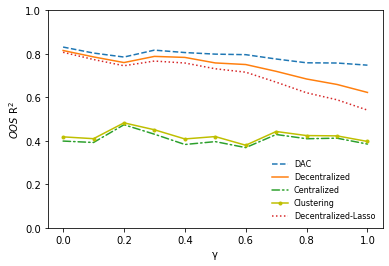

In [9]:
plt.plot(list_gamma, r2_alg_a10b30,"--",label = 'DAC')
plt.plot(list_gamma, r2_b1_a10b30,'',label = 'Decentralized')
plt.plot(list_gamma, r2_b2_a10b30,linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round',label = 'Centralized')
plt.plot(list_gamma, r2_clus_a10b30,'y-o',markersize=3,label = 'Clustering')
plt.plot(list_gamma, r2_lasso_a10b30,":",label = 'Decentralized-Lasso')


plt.legend(loc='lower right',frameon=False,prop={'size': 8})
plt.xlabel('γ')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()

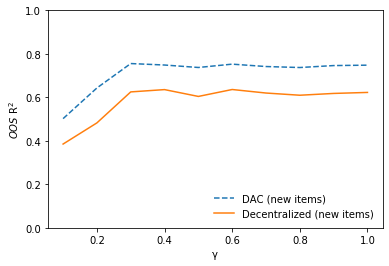

In [10]:
plt.plot(list_gamma[1:], r2_alg_new_a10b30[1:],"--",label = 'DAC (new items)')
plt.plot(list_gamma[1:],r2_b1_new_a10b30[1:],'',label = 'Decentralized (new items)')



plt.legend(loc='lower right',frameon=False,prop={'size': 10})
plt.xlabel('γ')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()

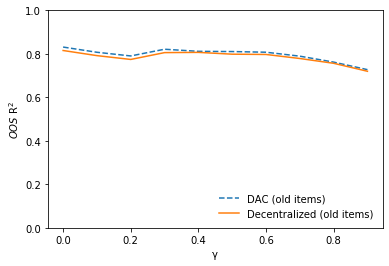

In [11]:
plt.plot(list_gamma[:10], r2_alg_old_a10b30[:10],"--",label = 'DAC (old items)')
plt.plot(list_gamma[:10],r2_b1_old_a10b30[:10],'',label = 'Decentralized (old items)')



plt.legend(loc='lower right',frameon=False,prop={'size': 10})
plt.xlabel('γ')
c1 = "2"
label = r'$OOS$ R$^{{{}}}$ '.format(c1)
plt.ylabel(label)
plt.ylim(0.0,1.0)
plt.show()